# Understanding Freshman Satisfaction and Retention in Higher Education
- Madelyn Redick
- Sahana Dhar
- Shawn Lokshin

## Abstract
This project investigates the qualities of universities that correspond to the amount of first year students that return for their second year. 
We obtained data from [The College Scorecard API](https://collegescorecard.ed.gov/data/documentation/) to collect various information regarding financials, admissions, and student bodies from colleges in the United States. 
We found that the most successful models for predicting retention rate was a Random Forest Regressor and a Linear Regression Model. The statistical analyses of these models can be found in the *Results* and *Discussion* section of this report. 
Using the models to analyze which features were most important, we found that SAT scores, faculty salaries, students' earnings after 6 years of entry, and the percentage of first generation students have the most impact on a school's retention rate. 
These results can be seen in the plots *Feature Importance - Random Forest Regressor* and *Feature Importance - Linear Regression*. 

## Introduction
Attending university is an important and popular choice for many American young adults; according to the Bureau of Labor Statistics, 61.8% of high school graduates were enrolled in college (2021). However, many institutions face a significant issue: retention rate. The quality of the university and freshman satisfaction impacts the amount of first year students who return for their second year. Colleges and unversities must continue adapting to the needs and expectations of the student bodies in order to maintain enrollment rates. 

Our project intends to understand the factors that are associated with a higher number of first-year students returning to a college. We will focus on relationships between a college's retention rate and their other attributes such as student student faculty ratio, average SAT score, and mean net price, among others. More specifically, we ask:
- What aspect is most strongly associated with a high retention rate?
- How do various institutional factors impact the likelihood of freshmen returning for their sophomore year?

The collected data will be used for comprehensive data analysis, allowing us to understand the  elationship between various college factors and the key questions of interest: (1) understanding the determinants of retention rate, and (2) assessing the impact of institutional characteristics on the likelihood of freshmen returning for another year. By discovering correlations in factors, employing machine learning techniques, our analysis aims to provide colleges and universities with predictive insights that can guide colleges to enlist changes and techniques that will enhance the quality of the freshman experience and improve retention rates.

## Data Description
We webscraped from an [alphabetical list of colleges in the USA](https://www.4icu.org/us/a-z/) to create a list of names of colleges. 
We are using [The College Scorecard API](https://collegescorecard.ed.gov/data/documentation/) from the US Department of Education to obtain our data. This API allows us to get robust data for a specific school. For each school in the list of college names, we will filter desired data from the API into an organized dataframe. 

In [1]:
# imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as stats
import pylab as py

In [2]:
'''
# ACCESSING API
api_key = 'fK3eae9BKJ8nZKxDTxtAPEXjfi02c3oAhK5aPCdx' #sahana's key
api_key = 'eNxKT9YQ2JbnD6J2TjemGwcGDOfdKwLutysmZ7YM' #madelyn's key
api_key = 'fK3eae9BKJ8nZKxDTxtAPEXjfi02c3oAhK5aPCdx' #shawn's key
base_url = 'http://api.data.gov/ed/collegescorecard/v1/schools'


# GETTING LIST OF COLLEGE NAMES
college_names = []
tables = pd.read_html('https://www.4icu.org/us/a-z/')
table_colleges = tables[0]

# flatten table
table_colleges.columns = table_colleges.columns.get_level_values(0)

# access the column names
table_colleges.columns = ['Rank', 'Name', 'Location']

# add each name to list
for college in table_colleges['Name']:
    college_names.append(college)
    
    
def calculate_diversity(div_dict):
    """ calculates the proportion of students of color
    Arguments:
        div_dict (dict): contains data for racial diversity
    
    Returns:
        sum(valid_values) (int): final value to represent proportion of students of color
    """
    valid_values = [value for key, value in div_dict.items() if value is not None and key != "white" and key != "white_2000"]
    return sum(valid_values)
    
# initialize empty dataframe
result_df = pd.DataFrame(columns=['College', 'SAT', 'Acceptance Rate', 'Earnings 6 yrs after entry', 
                                  'Share First Generation', 'Retention Rate', 'Student Faculty Ratio', 
                                    'Mean Net Price', 'Diversity', 'Students with Loans',
                                     'Faculty Salary'])

# CREATING DF
for college_name in college_names:
    params = {
        'api_key': api_key,
        'school.name': college_name,
    }

    while True:
        response = requests.get(base_url, params=params)
    
        if response.status_code == 200:
            data = response.json()
        
            # Extract the desired data
            try:
                data = data['results'][0]['latest']
                sat_score = data['admissions']['sat_scores']['average']['overall']
                acceptance_rate = data['admissions']['admission_rate']['overall']
                earnings = data['earnings']['6_yrs_after_entry']['median']
                first_gen_percentage = data['student']['share_firstgeneration']
                retention = data['student']['retention_rate']['overall']['full_time']
                student_faculty_ratio = data['student']['demographics']['student_faculty_ratio']
                mean_net_price = data['cost']['avg_net_price']['overall']
                poc_proportion = calculate_diversity(data["student"]["demographics"]["race_ethnicity"])
                with_loans = data["aid"]["students_with_any_loan"]
                faculty_salary = data['school']['faculty_salary']
                
            
                # Create a DataFrame for the current college
                data_dict = {
                    'College': [college_name],
                    'SAT': [sat_score],
                    'Retention Rate': [retention],
                    'Acceptance Rate': [acceptance_rate],
                    'Earnings 6 yrs after entry': [earnings],
                    'Share First Generation': [first_gen_percentage],
                    'Student Faculty Ratio' : [student_faculty_ratio],
                    'Mean Net Price' : [mean_net_price],
                    'Diversity': [poc_proportion],
                    'Students with Loans' : [with_loans],
                    'Faculty Salary' : [faculty_salary]
                }

                college_df = pd.DataFrame(data_dict)

                # Concatenate the college DataFrame to the result_df
                result_df = pd.concat([result_df, college_df], ignore_index=True)
                break  # Exit the retry loop if the request was successful
            
            except (KeyError, IndexError):
                print(f"Data not found for {college_name}")
                break  # Exit the retry loop if the data is not found

        elif response.status_code == 429:
            # Wait for a reasonable delay (e.g., 6 seconds) before retrying
            print(f'Rate limit exceeded for {college_name}. Waiting and then retrying...')
            time.sleep(6)
            
        else:
            print(f'API request failed with status code: {response.status_code} for {college_name}')
            break  

# SAVE TO CSV
result_df.to_csv('college_data.csv', index=False)
'''

'\n# ACCESSING API\napi_key = \'fK3eae9BKJ8nZKxDTxtAPEXjfi02c3oAhK5aPCdx\' #sahana\'s key\napi_key = \'eNxKT9YQ2JbnD6J2TjemGwcGDOfdKwLutysmZ7YM\' #madelyn\'s key\napi_key = \'fK3eae9BKJ8nZKxDTxtAPEXjfi02c3oAhK5aPCdx\' #shawn\'s key\nbase_url = \'http://api.data.gov/ed/collegescorecard/v1/schools\'\n\n\n# GETTING LIST OF COLLEGE NAMES\ncollege_names = []\ntables = pd.read_html(\'https://www.4icu.org/us/a-z/\')\ntable_colleges = tables[0]\n\n# flatten table\ntable_colleges.columns = table_colleges.columns.get_level_values(0)\n\n# access the column names\ntable_colleges.columns = [\'Rank\', \'Name\', \'Location\']\n\n# add each name to list\nfor college in table_colleges[\'Name\']:\n    college_names.append(college)\n    \n    \ndef calculate_diversity(div_dict):\n    """ calculates the proportion of students of color\n    Arguments:\n        div_dict (dict): contains data for racial diversity\n    \n    Returns:\n        sum(valid_values) (int): final value to represent proportion of stu

The code above displays our webscraping and API usage in order to build our DataFrame. Unfortunately, due to the rate limit of the API, we had to install a sleep timer in order to access all colleges without the API failing to return information. This led to our code taking approximately 80 minutes before the entire dataframe was built. For convenience, this code was only run once and immediately saved to a CSV, which was then used to complete the remainder of this project.

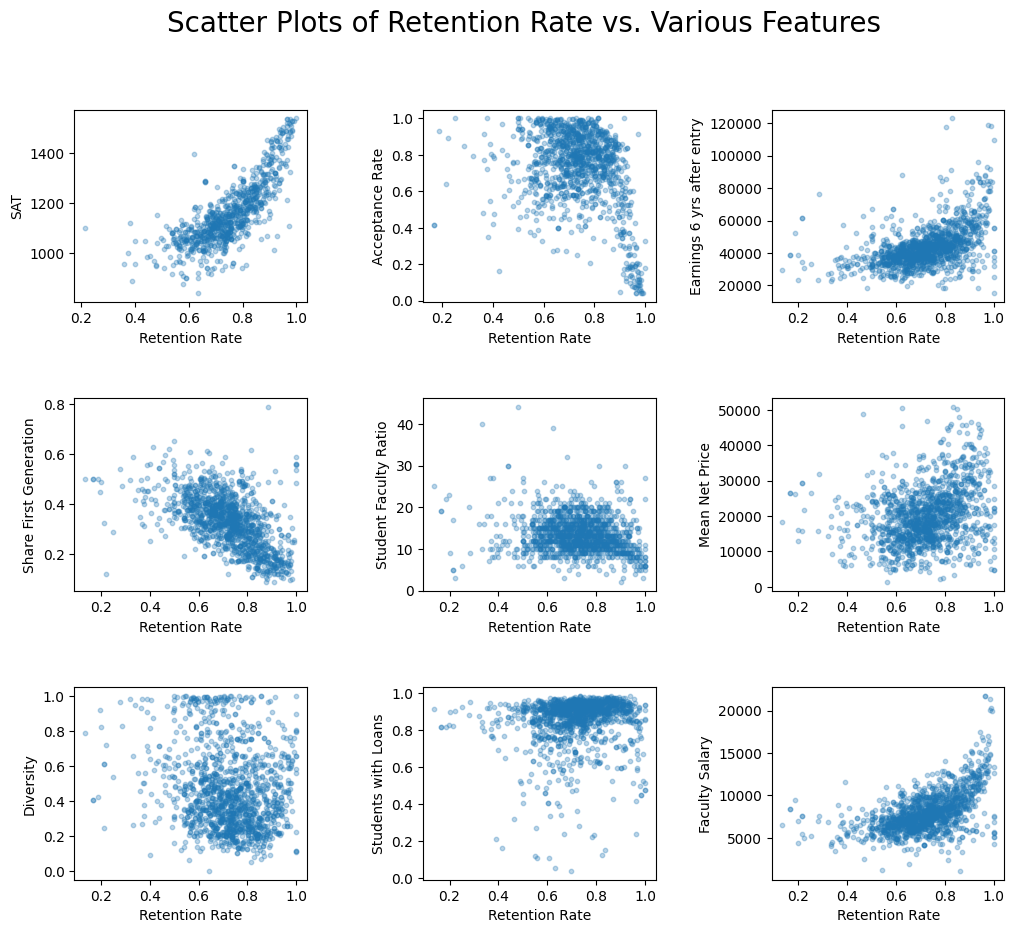

In [3]:
# convert csv to dataframe
df_colleges = pd.read_csv('college_data.csv')

# select numeric columns
columns = [item for item in df_colleges.columns if item not in ["Retention Rate", "College"]]

# create and format figure
plt.figure(figsize=(12, 10)) 
plt.suptitle("Scatter Plots of Retention Rate vs. Various Features", fontsize=20)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for idx, col in enumerate(columns):
    # activate specifc subplot
    plt.subplot(3, 3, idx+1)

    # plot scatter
    plt.scatter(df_colleges["Retention Rate"], df_colleges[col], s=10, alpha=0.3)
    plt.ylabel(col)
    plt.xlabel("Retention Rate")

## Method
The machine learning model that best fit for answering our questions is linear regression. Linear regression is used to predict a numeric variable y from various numeric variables x. Linear regression is important because it conveys $R^2$, the percentage of variance in y that can be explained by x. We considered feature selection techniques to maximize model accuracy and ensure the features elected are impactful. We calculated the $R^2$ and $MSE$ using linear regression with the most important features (SAT scores, share of first-generation students, and faculty salary) to predict a college's retention rate. In addition, we considered whether or not the model met the assumptions of a well-suited machine learning model. TODO - does it meet the assumptions

We also explored random forest regression to see if the results of both models matched each other. We found that the three most important features that contributed to a college's retention rate were SAT scores, faculty salary, and earnings 6 years after entry. 



**TODO...** 
- **Convince a technical expert that the method you chose is sound. Discuss any assumptions/pitfalls of the method and how they might impact the project.**
- **Educate an application expert on the broad outlines of the method you chose, providing a brief explanation of why this method is appropriate for the chosen problem.**

## Results

### Data Cleaning

In [4]:
# load csv
df_college = pd.read_csv('college_data.csv')

# remove NaN
df_college = df_college.dropna() # only leaves 794 rows

# standardize x features
cols = [list(df_college.columns)[i] for i in range(len(list(df_college.columns))) if i not in [0, 5]]
df_standardized = df_college[cols] / df_college[cols].std()

### Feature Importance for Random Forest Regressor

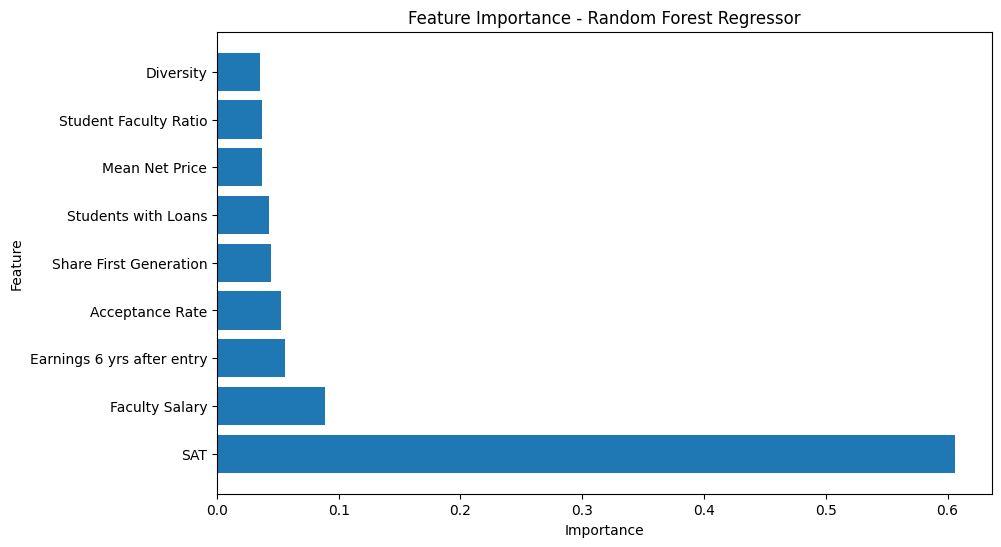

In [5]:
# distribute the dataset into two components X and y
X = df_standardized
y = df_college['Retention Rate']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on training data
rf_model.fit(X_train, y_train)

# get feature importances
feature_importances = rf_model.feature_importances_

# create a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest Regressor')
plt.show()

The above plot shows that SAT scores have a substantial impact on retention rate, with faculty salary, a student's earnings 6 years after their entrance to the school, and acceptance rate following behind. 

### Running RFR on Important Features & Visualizations

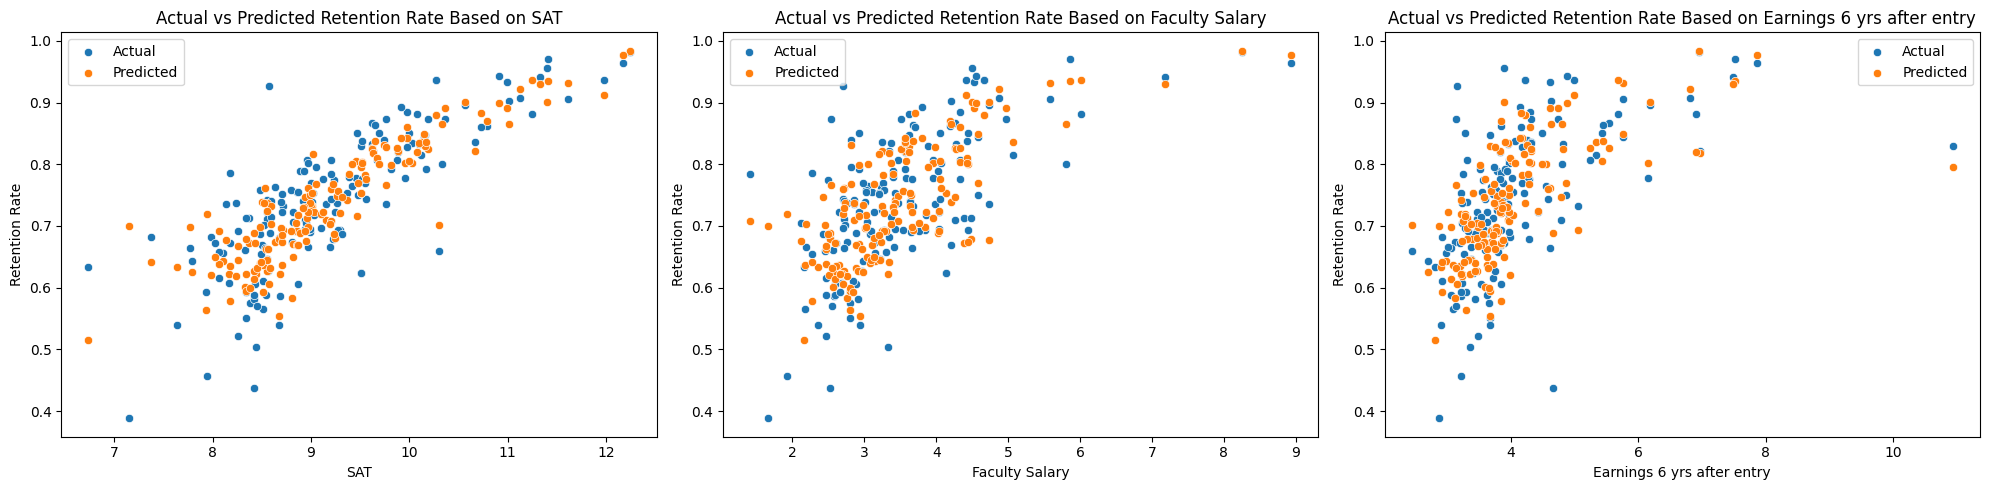

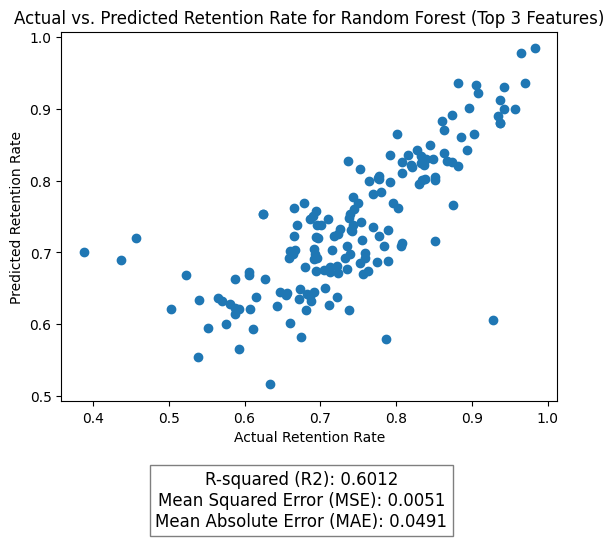

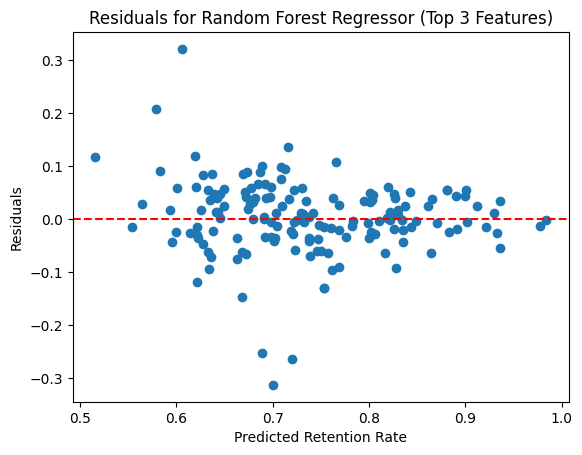

In [14]:
rf_features = ['SAT', 'Faculty Salary', 'Earnings 6 yrs after entry']

# define X and y
X = df_standardized[rf_features]
y = df_college['Retention Rate']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model on training data
rf_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf_model.predict(X_test)

# create a DataFrame with actual and predicted values
prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# plot actual vs predicted for each feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# iterate over features
for idx, feature in enumerate(X.columns):
    # scatter plot for Actual values
    sns.scatterplot(x=feature, y='Actual', data=pd.concat([X_test, prediction_df], axis=1), ax=axes[idx])
    
    # scatter plot for Predicted values
    sns.scatterplot(x=feature, y='Predicted', data=pd.concat([X_test, prediction_df], axis=1), ax=axes[idx])
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Retention Rate')
    axes[idx].set_title(f'Actual vs Predicted Retention Rate Based on {feature}')
    axes[idx].legend(['Actual', 'Predicted'])

# adjust layout
plt.tight_layout()
plt.show()

# calculate and display R2 score and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# feature Importances
feature_importances = rf_model.feature_importances_

# creating a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': feature_importances})

# sorting the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# predictions and residuals
y_pred = rf_model.predict(X_test)
residuals_selected = y_test - y_pred

# visualizing predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Retention Rate")
plt.ylabel("Predicted Retention Rate")
plt.title("Actual vs. Predicted Retention Rate for Random Forest (Top 3 Features)")

# calculate R2, MSE, and MAE
mse_selected = mean_squared_error(y_test, y_pred)
r2_selected = r2_score(y_test, y_pred)
mae_selected = mean_absolute_error(y_test, y_pred)

# display R2, MSE, and MAE
result_text = f'R-squared (R2): {r2_selected:.4f}\nMean Squared Error (MSE): {mse_selected:.4f}\nMean Absolute Error (MAE): {mae_selected:.4f}'
plt.figtext(0.5, -0.15, result_text, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# visualizing residuals
plt.scatter(y_pred, residuals_selected)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Retention Rate")
plt.ylabel("Residuals")
plt.title("Residuals for Random Forest Regressor (Top 3 Features)")
plt.show()

The scatterplot subplots show the predicted versus actual retention rates based on each feature included in the Random Forest Regressor; they show how well the model predicts retention rate based on the x features.

The plot entitled *Actual vs. Predicted Retention Rate for Random Forest Regressor (Top 3 Features)* shows the overall predicted versus retention rate from the model. 

The plot of the residuals for the Random Forest Regressor model with the top 3 features shows that the mean of the residuals of this model are mostly centered around 0 and there is no distinct pattern. Although there are outliers, they are minimal compared to the majority of the data. 

### Linear Regression Feature Importance

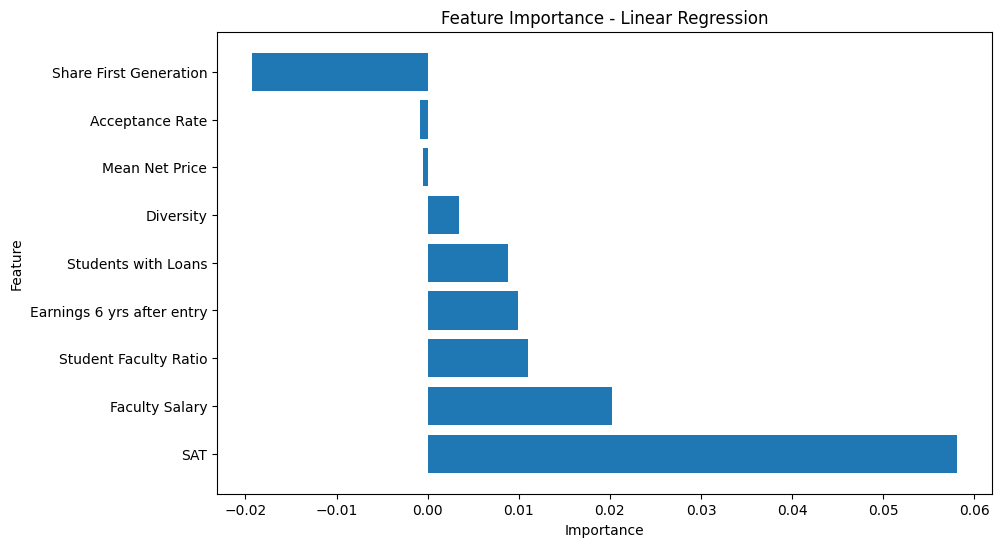

In [7]:
# extracting features and target variable
X = df_standardized
y = df_college['Retention Rate'].to_numpy()

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
lr_model = LinearRegression()

# fitting the model on training data
lr_model.fit(X_train, y_train)

# getting feature importances (coefficients)
feature_importances = lr_model.coef_

# creating a DataFrame to visualize feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# sorting the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Linear Regression')
plt.show()

The feature importance plot for the linear regression model shows that SAT scores have the highest impact on retention rate. Faculty salary and the percentage of first generation students are also impactful. SAT scores and faculty salary are positively related to retention rate, while the share of first generation students has a negative relationship with retention rate.

### Running LR on Important Features & Visualizations

In [44]:
def multiple_regression(cols):
    """ Fits a Multiple Linear Regression model to given columns.

    Arguments:
        cols (list): names of columns to be fed to Multiple Linear Regression.

    Returns:
        dictionary of relevant information of resulting model.
    """
    X = df_standardized[cols].to_numpy()
    y = df_college['Retention Rate'].to_numpy()

    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # create Linear Regression object to model the data
    linear_regression = LinearRegression()

    # train the model
    linear_regression.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = linear_regression.predict(X_test)

    # evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    residuals = y_test - y_pred

    # create subplots for residuals vs feature
    num_features = len(cols)
    fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5))

    # create a new figure for actual vs predicted plots
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(cols):
        plt.subplot(1, num_features, i+1)
        plt.scatter(X_test[:, i], y_test, label=f'Actual {feature}')
        plt.scatter(X_test[:, i], y_pred, label=f'Predicted {feature}', color='r', alpha=0.5)
        plt.legend()
        plt.xlabel(feature)
        plt.ylabel('Retention Rate')
        plt.title(f'Actual vs Predicted for {feature}')
        plt.suptitle(f'r2: {round(r2, 3)}, mse: {round(mse, 3)}, mae: {round(mae, 3)}')

    # plot residuals against each feature separately
    for i, feature in enumerate(cols):
        axes[i].scatter(x=X_test[:, i], y=residuals)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'Residuals vs {feature}')
        
    # residuals plot
    plt.figure(figsize=(8, 5))
    plt.scatter(x=range(len(residuals)), y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.title('Residuals In Order')

    # probability plot
    plt.figure(figsize=(8, 5))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Probability Plot')

    # adjust layout
    plt.tight_layout()
    plt.show()

    return {'mse': mse, 'r2': r2, 'mae': mae, 'residuals': residuals, 'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'features': cols}


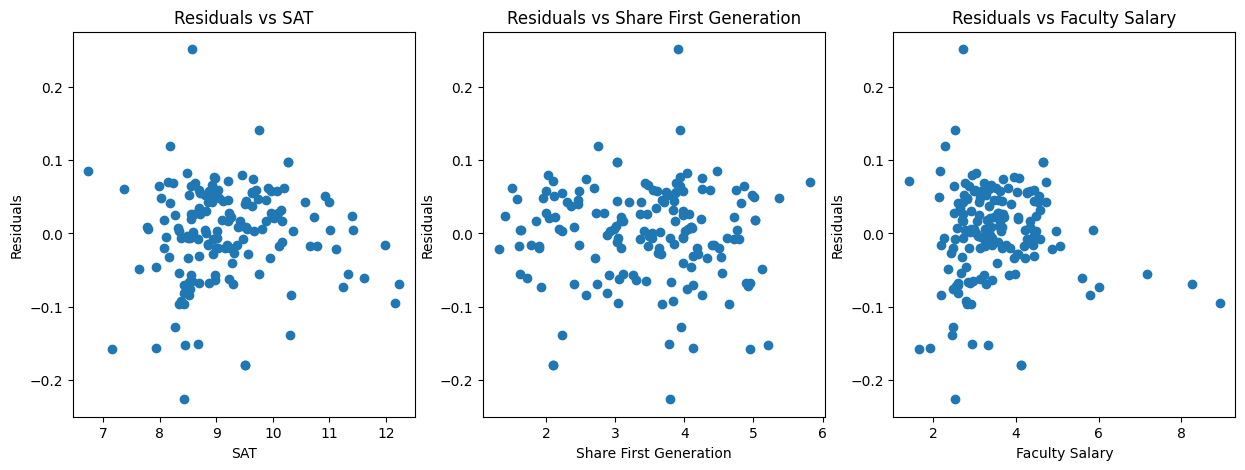

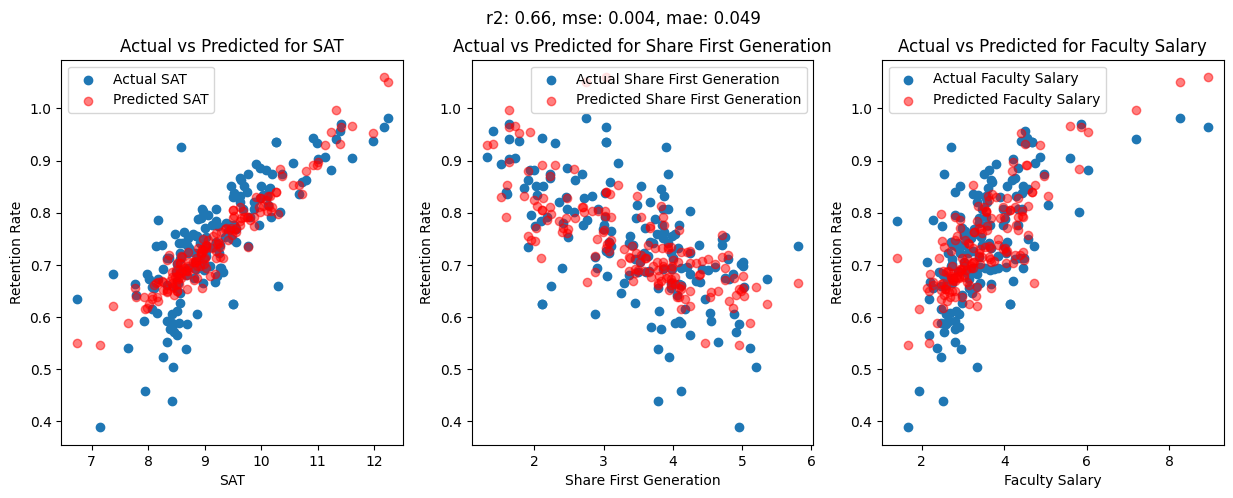

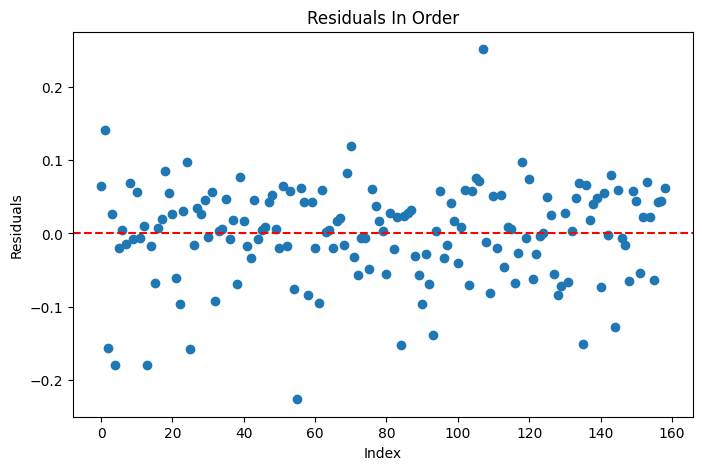

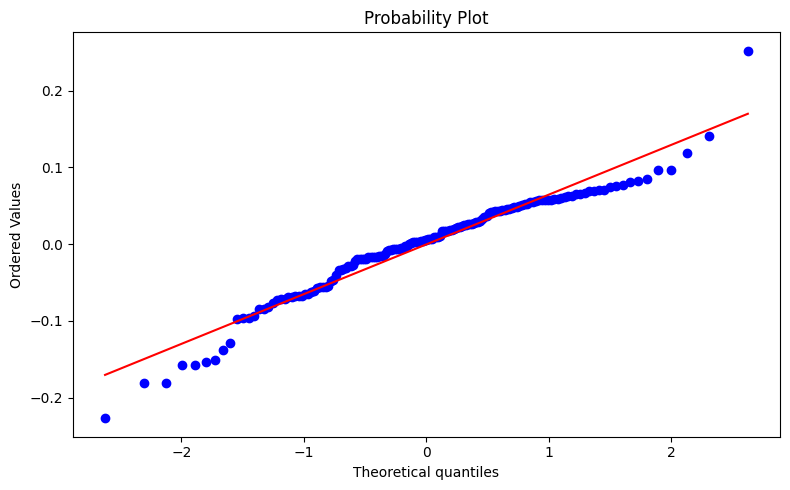

In [45]:
# fit a Multiple Linear Regression model with the top 3 features and visualize it
mult_reg_model = multiple_regression(['SAT', 'Share First Generation', 'Faculty Salary'])

The residuals plotted against each x feature show that for SAT scores and the share of first generation students, the residuals vary equally. The residuals against faculty salary show that while there is variance among the residuals, because the points are slightly clustered, it is not always constant.

The scatterplot subplots show the predicted versus actual retention rates based on each feature included in the Linear Regression Model; they show how well the model predicts retention rate based on the x features.

The residuals plotted in order show that the data are independent; the points are centered around 0 and there is no observable pattern.

The probability plot demonstrates that the residuals are normally distributed. The points representing the ordered residuals closely follow the 45 degree line that is expected with a well-fitted machine learning linear regression model. 

## Discussion

**interpret your results in the application context. Determine if you found solutions to your questions of interest and explain why/why not. Critique your results; should they be accepted at face value or were some assumptions made inappropriate? What actions should be taken (if any) as a result of the analysis, and how confident are you in these actions? What questions that were unanticipated arose from the analysis, and what should future work/analyses focus on?**

TODO